# Support Vector Regression

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
import cvxopt

## Generate synthetic dataset

In [2]:
# Generate sinusoidal data
np.random.seed(200)
x = np.random.uniform(low=-10, high=10, size=50)
x = np.sort(x)

# Generate t, with random Gaussian noise
t = np.sin(x/1.5)
e = np.random.normal(size=t.shape[0], scale=0.1)
t = t + e

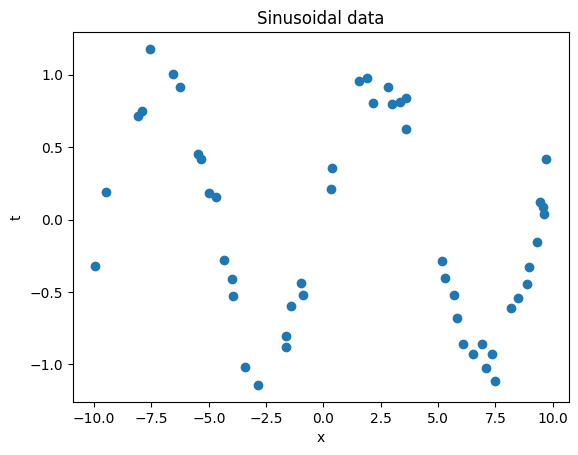

In [3]:
# Plot x and t
plt.scatter(x, t)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Sinusoidal data')
plt.show()

In [16]:
# Create dataset
X = x.reshape(-1, 1)
t = t

## Support Vector Regression implementation

In [46]:
def support_vector_regression(X_train, t_train, epsilon, C, gamma):
    """
    Find the parameters of X_train and t_train using Support Vector Regression
    :param X_train: train features
    :param t_train: train labels
    :param epsilon: control the sensitivity of the error function
    :param C: control the trade-off
    :param gamma: control the RBF kernel function
    :return: the parameters w and b of Support Vector Regression
    """
    # Get the dimension
    N = t_train.shape[0]
    
    # Find the Gram matrix using the RBF kernel function
    gram = rbf_kernel(X_train, gamma=gamma)
    
    # Solve of a
    P = np.hstack((gram, -gram))
    P = np.vstack((P, -P))
    P = cvxopt.matrix(P)    

    q = epsilon * np.ones(N * 2) - np.concatenate((t, -t))
    q = cvxopt.matrix(q)
    
    G = np.vstack((np.eye(N * 2), -np.eye(N * 2)))
    G = cvxopt.matrix(G)
    
    h = np.array([C] * (N * 2) + [0.0] * (N * 2))
    h = cvxopt.matrix(h)
    
    sol = cvxopt.solvers.qp(P, q, G, h)
    a = np.array(sol['x']).reshape(-1)
    
    # Use a to calculate b
    a_1 = a[:N]
    a_2 = a[N:]
    
    # Find specific data points which have 0 < a < C
    x_specific = X_train[np.logical_and(a_1 > 0, a_1 < C), :]
    t_specific = t_train[np.logical_and(a_1 > 0, a_1 < C)]
    
    # Solve for b
    b = 0
    for i in range(x_specific.shape[0]):
        x_current = x_specific[i]
        t_current = t_specific[i]
        k = rbf_kernel(X_train, x_current.reshape(1, -1), gamma=gamma).reshape(-1)
        b += t_current - epsilon - np.dot(a_1 - a_2, k)
        
    b = b / x_specific.shape[0]
    return a, b


def predict(X_train, a, b, X_test, gamma):
    """
    Perform prediction using found parameters
    :param X_train: train features
    :param a: a parameters
    :param b: parameter
    :param X_test: test points
    :param gamma: RBF kernel parameters
    :return: the predictions
    """
    # Split a into two vectors
    N = X_train.shape[0]
    a_1 = a[:N]
    a_2 = a[N:]
    
    # Predictions
    predictions = []
    
    # Make predictions
    for x_test in X_test:
        k = rbf_kernel(X_train, x_test.reshape(1, -1), gamma=gamma).reshape(-1)
        y = np.dot(a_1 - a_2, k) + b
        predictions.append(y)
        
    return np.array(predictions)

     pcost       dcost       gap    pres   dres
 0:  1.5708e+00 -1.2164e+02  1e+02  4e-17  1e-15
 1:  8.3886e-01 -8.4007e+00  9e+00  1e-16  1e-15
 2: -2.1160e+00 -3.9073e+00  2e+00  1e-16  9e-16
 3: -2.7562e+00 -3.1601e+00  4e-01  2e-16  6e-16
 4: -2.9172e+00 -2.9781e+00  6e-02  2e-16  4e-16
 5: -2.9421e+00 -2.9473e+00  5e-03  2e-16  5e-16
 6: -2.9441e+00 -2.9448e+00  7e-04  2e-16  4e-16
 7: -2.9444e+00 -2.9445e+00  2e-05  2e-16  4e-16
 8: -2.9444e+00 -2.9444e+00  2e-07  2e-16  4e-16
Optimal solution found.


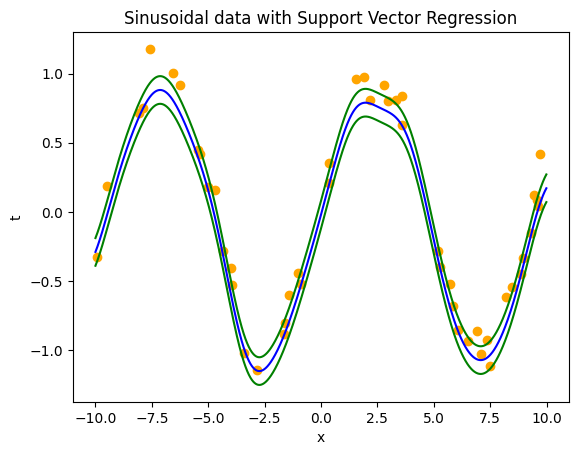

In [60]:
# Define epsilon, C and gamma
epsilon = 0.1
C = 1
gamma = 0.5

# Find parameters a and b
a, b = support_vector_regression(X, t, epsilon=epsilon, C=1, gamma=0.5)

# Make predictions
X_test = np.arange(-10, 10, 0.01)
predictions = predict(X, a, b, X_test, gamma=0.5)

# Plot predictions
plt.plot(X_test, predictions, color='blue')
plt.plot(X_test, predictions - epsilon, color='green')
plt.plot(X_test, predictions + epsilon, color='green')
plt.scatter(x, t, color='orange')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Sinusoidal data with Support Vector Regression')
plt.savefig('figures/support_vector_regression.png')
plt.show()